# Simulate and estimate a very simple Bayesian causal model

In [1]:
import math
import os
import scipy.stats as stats
import numpy as np
import seaborn as sns
import logging
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.distributions.constraints as constraints
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

import pyro
from pyro.nn import PyroModule, PyroSample
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist

/home/ssm-user/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Simulate a latent variable model with perturbations

In [3]:
# Experiment parameters
n_perturb = 10
n_latent = 5
n_features = 20
n_obs = 1000

# Prior distributions
latent_mean = 0
latent_std = 1

# Define perturbation-latent space effect, should be sparse
beta = stats.norm.rvs(scale=2, size=(n_perturb, n_latent))
beta_mask = np.random.choice([0, 1], size=(n_perturb, n_latent)).astype(bool)
beta[beta_mask] = 0

# Define latent-feature mapping, should be sparse
W = stats.norm.rvs(scale=2, size=(n_latent, n_features))
b = stats.norm.rvs(size=(1, n_features))
W_mask = np.random.choice([0, 1], size=(n_latent, n_features)).astype(bool)
W[W_mask] = 0

In [88]:
# Generate the guide assignment matrix
P = np.zeros((n_obs,n_perturb), dtype=float)
for i in range(n_obs):
    P[i, np.random.choice(n_perturb)] = 1.

# Generate the latent space variables
Z = stats.norm.rvs(loc=latent_mean, scale=latent_std, size=(n_obs, n_latent))
Z += P@beta

# Generate means for X's
X_means = Z@W+b
X = stats.norm.rvs(loc=X_means, scale=1.5)

X = torch.tensor(X).float().cuda()
P = torch.tensor(P).float().cuda()
Z = torch.tensor(Z).float().cuda()

In [89]:
device = X.device

In [90]:
def tfn(value, device=device):
    
    return torch.tensor(value, device=device)

In [91]:
def reset_model_weights(layer):
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()
    else:
        if hasattr(layer, 'children'):
            for child in layer.children():
                reset_model_weights(child)

### "Normal" VAE

In [125]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

In [155]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat = self.Decoder(z)
        
        return x_hat, mean, log_var

In [178]:
from torch.optim import Adam

mseloss = nn.MSELoss(reduction='sum')

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = mseloss(x_hat, x)
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=1e-3)

In [185]:
batch_size=100
dataset = TensorDataset(X)
dataloader = DataLoader(dataset, batch_size=batch_size)

encoder = Encoder(input_dim=n_features, hidden_dim=n_latent, latent_dim=n_latent)
decoder = nn.Linear(n_latent, n_features)

model = Model(Encoder=encoder, Decoder=decoder).to(device)

In [186]:
print("Start training VAE...")

reset_model_weights(model)

# model.train()

epochs=500
for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, x in enumerate(dataloader):
        x = torch.cat(x)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 50 == 0:
        print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

Start training VAE...
	Epoch 50 complete! 	Average Loss:  776.0977300347222
	Epoch 100 complete! 	Average Loss:  779.2550477430556
	Epoch 150 complete! 	Average Loss:  775.8114626736111
	Epoch 200 complete! 	Average Loss:  774.7838237847222
	Epoch 250 complete! 	Average Loss:  775.9198090277778
	Epoch 300 complete! 	Average Loss:  776.8782552083334
	Epoch 350 complete! 	Average Loss:  774.9284114583334
	Epoch 400 complete! 	Average Loss:  778.1596744791667
	Epoch 450 complete! 	Average Loss:  777.1637760416667
	Epoch 500 complete! 	Average Loss:  775.4198871527777


Text(0.5, 1.0, 'Reconstructing the output X')

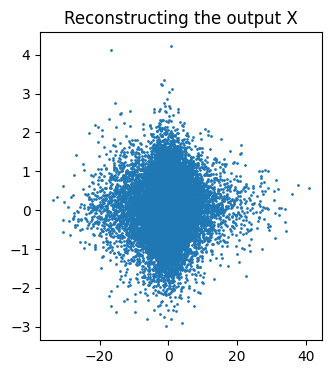

In [176]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
x = X.cpu().numpy().ravel()
x_hat = model(X)[0].detach().cpu().numpy().ravel()
plt.scatter(x,x_hat, s=1)
plt.title('Reconstructing the output X')

# plt.subplot(1, 2, 2)
# z = Z.cpu().numpy().ravel()
# z_hat = model.encode(X).cpu().detach().numpy().ravel()
# plt.scatter(z,z_hat, s=1)
# plt.title('Reconstructing the latent variables (code) Z')

### "Normal" autoencoder

In [92]:
class AE(nn.Module):
    def __init__(self, n_features, n_latent, n_hidden):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=n_features, out_features=n_hidden
        )
        self.encoder_output_layer = nn.Linear(
            in_features=n_hidden, out_features=n_latent
        )
        self.decoder = nn.Linear(
            in_features=n_latent, out_features=n_features
        )

        
    def encode(self, features):
        
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        
        return code
    
    
    def decode(self, code):
        
        reconstructed = self.decoder(code)
        return reconstructed
    
    
    def forward(self, features):
        code = self.encode(features)
        return self.decode(code)

In [93]:
dataset = TensorDataset(X)
dataloader = DataLoader(dataset, batch_size=100)

In [94]:
# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(n_features=n_features, n_latent=n_latent, n_hidden=int(n_latent*2)).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=5e-3)

# mean-squared error loss
criterion = nn.MSELoss()

In [95]:
reset_model_weights(model)


In [96]:
epochs = 100
reset_model_weights(model)

for epoch in range(epochs): 
    loss = 0
    for batch_features in dataloader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = torch.cat(batch_features).view(-1, n_features).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features) + 0.01 * torch.norm(model.decoder.weight, 1)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(dataloader)
    
    # display the epoch training loss
    if epoch % 100 == 0:
        print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))
    

epoch : 1/100, loss = 34.171426


Text(0.5, 1.0, 'Reconstructing the latent variables (code) Z')

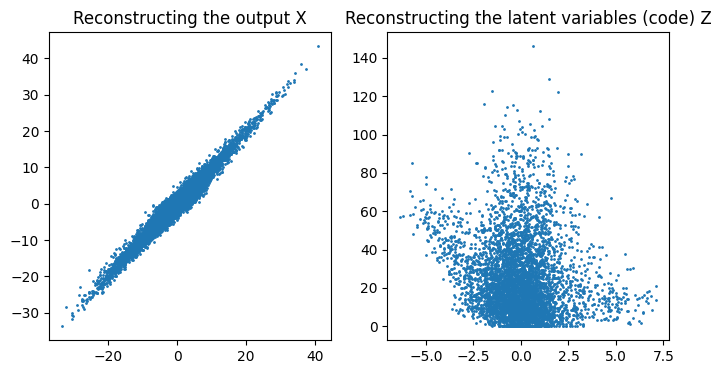

In [97]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
x = X.cpu().numpy().ravel()
x_hat = model(X).detach().cpu().numpy().ravel()
plt.scatter(x,x_hat, s=1)
plt.title('Reconstructing the output X')

plt.subplot(1, 2, 2)
z = Z.cpu().numpy().ravel()
z_hat = model.encode(X).cpu().detach().numpy().ravel()
plt.scatter(z,z_hat, s=1)
plt.title('Reconstructing the latent variables (code) Z')

### Autoencoder with Perturbation guide for latent space

In [98]:
class PerturbAE(nn.Module):
    def __init__(self, n_features, n_latent, n_hidden, n_perturb):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=n_features, out_features=n_hidden
        )
        self.encoder_output_layer = nn.Linear(
            in_features=n_hidden, out_features=n_latent
        )
        self.decoder = nn.Linear(
            in_features=n_latent, out_features=n_features
        )
        self.perturb = nn.Linear(
            in_features=n_perturb, out_features=n_latent, bias=False
        )

        
    def encode(self, features):
        
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        
        return code
    
    
    def decode(self, code):
        
        reconstructed = self.decoder(code)
        return reconstructed
    
    
    def perturb_effect(self, perturb_ind):
        
        return self.perturb(perturb_ind)
    
    
    def forward(self, features, perturb_ind):
        code = self.encode(features)
        delta = self.perturb_effect(perturb_ind)
        return self.decode(code+delta)

In [99]:
dataset = TensorDataset(X, P)
dataloader = DataLoader(dataset, batch_size=100)

In [100]:
# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = PerturbAE(n_features=n_features, n_latent=n_latent, n_hidden=n_latent, n_perturb=n_perturb).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-2)

# mean-squared error loss
criterion = nn.MSELoss()

In [101]:
epochs = 1000
lambda1 = 5
lambda2 = 5
reset_model_weights(model)
for epoch in range(epochs): 
    loss = 0
    for batch_features, perturb_features in dataloader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
#         batch_features = torch.cat(batch_features).view(-1, n_features).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features, perturb_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features) + lambda1 * torch.norm(model.perturb.weight, 1) + lambda2 * torch.norm(model.decoder.weight, 1)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(dataloader)
    
    # display the epoch training loss
    if epoch % 100 == 0:
        print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))
    

epoch : 1/1000, loss = 153.409852
epoch : 101/1000, loss = 11.747341
epoch : 201/1000, loss = 8.787115
epoch : 301/1000, loss = 7.937686
epoch : 401/1000, loss = 7.527676
epoch : 501/1000, loss = 7.211228
epoch : 601/1000, loss = 6.998796
epoch : 701/1000, loss = 6.978863
epoch : 801/1000, loss = 6.876640
epoch : 901/1000, loss = 6.869465


In [102]:
criterion(Z, P@torch.tensor(beta, device=device).float())

tensor(1.0026, device='cuda:0')

In [103]:
criterion(model.perturb(P)+model.encode(X), Z)

tensor(201466.2031, device='cuda:0', grad_fn=<MseLossBackward0>)

In [ ]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
x = X.cpu().numpy().ravel()
x_hat = model(X).detach().cpu().numpy().ravel()
plt.scatter(x,x_hat, s=1)
plt.title('Reconstructing the output X')

plt.subplot(1, 2, 2)
z = Z.cpu().numpy().ravel()
z_hat = model.encode(X).cpu().detach().numpy().ravel()
plt.scatter(z,z_hat, s=1)
plt.title('Reconstructing the latent variables (code) Z')

Text(0.5, 1.0, 'Reconstructing the latent variables (code) Z')

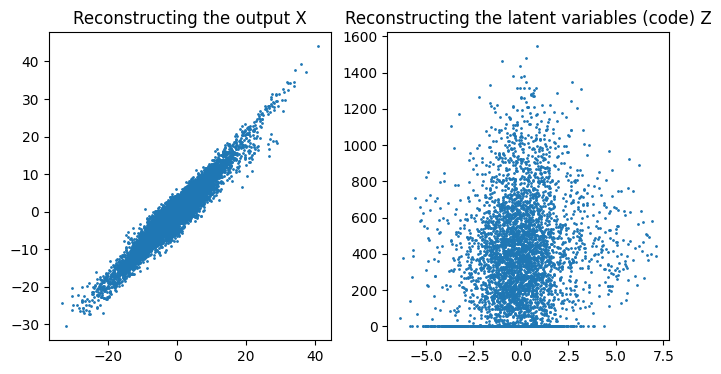

In [108]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
x = X.cpu().numpy().ravel()
x_hat = model(X, P).cpu().detach().numpy().ravel()
plt.scatter(x,x_hat, s=1)
plt.title('Reconstructing the output X')

plt.subplot(1, 2, 2)
z = Z.cpu().numpy().ravel()
z_hat = (model.encode(X)+model.perturb(P)).cpu().detach().numpy().ravel()
plt.scatter(z,z_hat, s=1)
plt.title('Reconstructing the latent variables (code) Z')

### Create a Pyro model

In [67]:
class Encoder(nn.Module):
    def __init__(self, n_features, z_dim, hidden_dim):
        super().__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(n_features, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        # then compute the hidden units
        hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

In [93]:
class CausalLDAE():
    
    def __init__(self, n_perturb, n_latent, n_features):
        
        self.n_perturb = n_perturb
        self.n_latent = n_latent
        self.n_features = n_features
                
        # Define encoder
        self.encoder = Encoder(n_features, n_latent, int(n_latent/2)).to(device)
        
        # Define decoder
        self.decoder = nn.Linear(n_latent, n_features).to(device)

    def model(self, x, p):
        
        pyro.module("decoder", self.decoder)
        
        # Sample the variance used for observed data generation
        sigma = pyro.sample("sigma", dist.Uniform(tfn(0.), tfn(10.)))

        # Sample beta
        prior_es_mean = torch.zeros((self.n_perturb, self.n_latent), device=device)
        prior_es_var = torch.ones((self.n_perturb, self.n_latent), device=device)
        beta = pyro.sample('beta', dist.Normal(prior_es_mean, prior_es_var).to_event(2))

        # Sample the mask probabilities
        prior_a = torch.ones((self.n_perturb, self.n_latent), device=device)
        prior_b = torch.ones((self.n_perturb, self.n_latent), device=device)*n_perturb
        mask_prob = pyro.sample('mask_prob', dist.Beta(prior_a, prior_b).to_event(2))

        # Sample the mask
        mask = pyro.sample('mask', dist.ContinuousBernoulli(probs=mask_prob).to_event(2))

        # Compute means by masking the effects
        masked_beta = beta*mask 
        
        with pyro.plate("data", x.shape[0]):
            # Define mean and variance for z's
            z_loc = p@masked_beta
            z_scale = x.new_ones(torch.Size((x.shape[0], self.n_latent)))      

            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            
            obs_loc = self.decoder(z)
            pyro.sample("obs", dist.Normal(obs_loc, sigma).to_event(1), obs=x)
    
    def guide(self, x, p):
        
        pyro.module("encoder", self.encoder)
        
        # Sample the sigma
        sigma_loc = pyro.param('sigma_loc', torch.tensor(1., device=device), constraint=constraints.positive)
        sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))

        # Sample beta
        q_es_mean = pyro.param(
            "q_es_mean", 
            torch.zeros((self.n_perturb, self.n_latent), device=device))
        q_es_var = pyro.param(
            "q_es_var", 
            torch.ones((self.n_perturb, self.n_latent), device=device),
            constraint=constraints.positive)
        beta = pyro.sample('beta', dist.Normal(q_es_mean, q_es_var).to_event(2))

        # Sample the mask probabilities
        q_mp = pyro.param('q_mp', torch.ones((self.n_perturb, self.n_latent), device=device)/tfn(self.n_perturb), constraint=constraints.unit_interval)
        mask_prob = pyro.sample('mask_prob', dist.Delta(q_mp).to_event(2))

        # Sample the mask itself
        q_p = pyro.param('q_p', torch.ones((self.n_perturb, self.n_latent), device=device)/tfn(self.n_perturb), constraint=constraints.unit_interval)
        mask = pyro.sample('mask', dist.ContinuousBernoulli(probs=q_p).to_event(2))
                
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            
            z_shift = p@beta
            z_loc, z_scale = self.encoder(x)
            pyro.sample("latent", dist.Normal(z_loc+z_shift, z_scale).to_event(1))
            

### Train the Pyro model

In [94]:
cldae = CausalLDAE(n_perturb, n_latent, n_features)

In [102]:
optimizer = Adam({"lr": 1.0e-4})


In [103]:
svi = SVI(cldae.model, cldae.guide, optimizer, loss=Trace_ELBO())


In [104]:
pyro.clear_param_store()
for j in range(5000):
    # calculate the loss and take a gradient step
    loss = svi.step(X, P)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(X)))

[iteration 0001] loss: 191.7292
[iteration 0101] loss: 136.6374
[iteration 0201] loss: 163.7305
[iteration 0301] loss: 150.4883
[iteration 0401] loss: 112.8856
[iteration 0501] loss: 133.5374
[iteration 0601] loss: 116.5425
[iteration 0701] loss: 129.3682
[iteration 0801] loss: 117.5032
[iteration 0901] loss: 113.8185


### SUPER simple SPARSE bayesian regression

In [18]:
beta = 1
n= 1000
labels = np.random.choice(2, size=n)
means = beta*labels
data = stats.norm.rvs(means, 1)

labels = torch.tensor(labels)#.cuda()
data = torch.tensor(data)#.cuda()
device = labels.device



In [19]:
def model(data, label):
    
    # Effect size 
    prior_es_mean = tfn(0)
    prior_es_variance = tfn(10)
    effect_size = pyro.sample('es', dist.Normal(prior_es_mean, prior_es_variance))
    
    # Mask probability
    
    
    means = label*effect_size
    
    with pyro.plate("data", len(data)):
        pyro.sample('x', dist.Normal(means, tfn(1.)), obs=data)
    
def guide(x, label):
    
    mean_q = pyro.param('mean_q', tfn(0.))
    var_q = pyro.param('var_q', tfn(1.), constraint=constraints.positive)
    
    pyro.sample('es', dist.Normal(mean_q, var_q))

In [20]:
adam_params = {"lr": 0.001, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

In [21]:
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())


In [26]:
n_steps = 5000
# do gradient steps
for step in range(n_steps):
    svi.step(data, labels)

In [22]:
stats.linregress(labels.to('cpu'), data.to('cpu'))

LinregressResult(slope=1.1774769409629444, intercept=-0.0955352396145398, rvalue=0.4942095440947383, pvalue=1.0464228499301985e-62, stderr=0.06556424736958555, intercept_stderr=0.04686811968102247)

In [23]:
stats.linregress(labels.to('cpu'), data.to('cpu'))

LinregressResult(slope=1.1774769409629444, intercept=-0.0955352396145398, rvalue=0.4942095440947383, pvalue=1.0464228499301985e-62, stderr=0.06556424736958555, intercept_stderr=0.04686811968102247)

In [24]:
print(n, pyro.param('mean_q').item(), pyro.param('var_q').item())

KeyError: 'mean_q'

In [129]:
print(n, pyro.param('mean_q').item(), pyro.param('var_q').item())

10000 2.9410760402679443 0.5252532362937927


In [124]:
# print(n, pyro.param('mean_q').item(), pyro.param('var_q').item())

1000 2.9311881065368652 0.5552800297737122


In [116]:
print('1000', pyro.param('mean_q').item(), pyro.param('var_q').item())

1000 2.922926902770996 0.5885440111160278


In [ ]:
 def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

In [ ]:
def model(X):
    
    _beta = pyro.sample("beta", dist.Normal(0, 1))
    
    
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness
    with pyro.plate("data", len(ruggedness)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

In [159]:
def model(is_cont_africa, ruggedness, log_gdp):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness
    with pyro.plate("data", len(ruggedness)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

In [87]:
P@beta

ValueError: matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

In [81]:
Z

array([[-1.91002742, -0.92186503, -1.08265123,  0.10128784,  1.13183064],
       [-0.27033453,  0.09442541, -0.21412823, -1.0213405 , -0.04262896],
       [ 0.25084065,  0.22240159,  0.17268779,  0.25823634, -0.04667609],
       ...,
       [ 0.72570834,  0.65298513, -0.28390392, -1.10068273, -0.46834919],
       [ 0.21971457,  1.48248596, -0.59271296,  1.06924575,  0.57892723],
       [-0.24633521, -1.06654928, -0.4405091 ,  0.97873046,  0.77464404]])

In [76]:
P

array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0]])

In [69]:
Z.shape

(1000,)

In [49]:
beta

array([[ 0.        , -1.18208369,  0.        ,  0.        ,  0.        ],
       [ 0.80622373, -0.25971326,  1.73093022,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.61205513,  2.68592717,  0.24531006, -2.3916667 ],
       [ 0.        ,  1.86658371,  0.        ,  0.02836729,  0.        ]])

In [20]:
# def model(data):

#     # sample f from the Beta prior
#     f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    
#     # loop over the observed data
#     for i in range(len(data)):
#         # observe datapoint i using the Bernoulli
#         # likelihood Bernoulli(f)
#         pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])
        
def model(data):
    
    # define the hyperparameters that control the Beta prior
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.0)
    
    # sample f from the beta prior
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    # loop over the observed data [WE ONLY CHANGE THE NEXT LINE]
    for i in pyro.plate("data_loop", len(data)):
        # observe datapoint i using the bernoulli likelihood
        pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])

In [21]:
def guide(data):
    
    # register the two variational parameters with Pyro.
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0),
                         constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(15.0),
                        constraint=constraints.positive)
    
    # sample latent_fairness from the distribution Beta(alpha_q, beta_q)
    pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

In [22]:
# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
n_steps = 2 if smoke_test else 2000

assert pyro.__version__.startswith('1.8.5')

# clear the param store in case we're in a REPL
pyro.clear_param_store()

# create some data with 6 observed heads and 4 observed tails
data = []
for _ in range(6):
    data.append(torch.tensor(1.0))
for _ in range(4):
    data.append(torch.tensor(0.0))

In [23]:
# set up the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

n_steps = 5000
# do gradient steps
for step in range(n_steps):
    svi.step(data)

In [24]:
# grab the learned variational parameters
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

# here we use some facts about the Beta distribution
# compute the inferred mean of the coin's fairness
inferred_mean = alpha_q / (alpha_q + beta_q)

# compute inferred standard deviation
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * math.sqrt(factor)

print("\nBased on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))


Based on the data and our prior belief, the fairness of the coin is 0.531 +- 0.090
